In [ ]:
%load_ext autoreload
%autoreload 2

# Text: Core

> The `text.core` module contains the core bits required to use fast.ai's low-level and/or mid-level APIs to build `DataLoaders` and train NLP/Text sequence classification models 

In [ ]:
# |default_exp text.core
# |default_cls_lvl 3

In [ ]:
# |export
from __future__ import annotations

import gc, importlib, sys, traceback

from accelerate.logging import get_logger
from dataclasses import dataclass
from datasets import concatenate_datasets, load_dataset
from dotenv import load_dotenv
from fastai.callback.all import *
from fastai.imports import *
from fastai.learner import *
from fastai.losses import BaseLoss, BCEWithLogitsLossFlat, CrossEntropyLossFlat
from fastai.data.transforms import DataLoaders, Datasets, ColSplitter, ItemTransform
from fastai.optimizer import Adam, OptimWrapper, params
from fastai.metrics import accuracy, F1Score, accuracy_multi, F1ScoreMulti
from fastai.test_utils import show_install
from fastai.torch_core import *
from fastai.torch_imports import *
from transformers import (
    AutoConfig,
    AutoTokenizer,
    PretrainedConfig,
    PreTrainedTokenizerBase,
    PreTrainedModel,
)
from transformers import AutoModelForSequenceClassification
from transformers import logging as hf_logging
from transformers.data.data_collator import DataCollatorWithPadding

from blurr.utils import clean_memory, get_hf_objects, set_seed, PreCalculatedLoss

In [ ]:
# |hide
import pdb

from fastai.data.block import (
    CategoryBlock,
    ColReader,
    ColSplitter,
    DataBlock,
    ItemGetter,
    RandomSplitter,
)
from fastai.text.data import SortedDL
from fastcore.test import *
import nbdev

from blurr.utils import (
    print_versions,
    PreCalculatedCrossEntropyLoss,
    PreCalculatedBCELoss,
    PreCalculatedMSELoss,
)

In [ ]:
# |export
# silence all the HF warnings and load environment variables
warnings.simplefilter("ignore")
hf_logging.set_verbosity_error()
logger = get_logger(__name__)

load_dotenv()

False

In [ ]:
# |hide
# |notest
torch.cuda.set_device(0)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")

Using GPU #0: NVIDIA GeForce RTX 3090


In [ ]:
# | echo: false
os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")

What we're running with at the time this documentation was generated:
torch: 1.13.1
fastai: 2.7.11
transformers: 4.26.1


## Setup

We'll use a subset of `imdb` to demonstrate how to configure your BLURR for sequence classification tasks. **BLURR** is designed to work with Hugging Face `Dataset` and/or pandas `DataFrame` objects

In [ ]:
imdb_dsd = load_dataset("imdb", split=["train", "test"])

# build HF `Dataset` objects
train_ds = (
    imdb_dsd[0]
    .add_column("is_valid", [False] * len(imdb_dsd[0]))
    .shuffle()
    .select(range(1000))
)
valid_ds = (
    imdb_dsd[1]
    .add_column("is_valid", [True] * len(imdb_dsd[1]))
    .shuffle()
    .select(range(200))
)

# build a `DataFrame` representation as well
imdb_ds = concatenate_datasets([train_ds, valid_ds])
imdb_df = pd.DataFrame(imdb_ds)

print(len(train_ds), len(valid_ds))
print(
    len(imdb_df[imdb_df["is_valid"] == False]),
    len(imdb_df[imdb_df["is_valid"] == True]),
)
imdb_df.head()

Found cached dataset imdb (/home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/2 [00:00<?, ?it/s]

1000 200
1000 200


,text,label,is_valid
0,"Witchy Hildegard Knef traps a group of people in an isolated hotel and picks them off one by one in twisted, disgusting ways. I thought I'd seen it all until one unfortunate man here is crucified and then has his head set on fire. Hildy is quite the prankster too: she takes a nagging harpy and sews her mouth shut...then hangs her upside down in the chimney just in time for a roaring fire! ""Witchery"" made me sick. It made my eyes hurt. I was ready to write it off as the worst movie ever-ever-ever made by otherwise competent people...until the finale. I have to admit I loved the ending. It i...",0,False
1,"""Whipped"" is 82 minutes long. This review is 82 words long. Three unlikable New York Lotharios, ruthless ""scammers,"" end up wooing the same woman, played by Amanda Peet, with disastrous results. That applies to the story and the film. Too sophomoric to be misogynistic, flaccid and ridiculous, ""Whipped"" mixes the philosophies of shock jock Tom Lykis with Penthouse letter fantasies. Though technically proficient it's dated, grating, poorly written, mean, and obvious. People don't act like this. People don't talk like this. Really.",0,False
2,"Oh man is this movie bad. It flows horribly. The story is about a race car driver who is in love with himself, and then has to promote a chicken fast food chain and while doing this, doesn't love himself. He tries getting out of the contract and horrible, painfully unfunny gags ensue. Jim Nabors seems as if he's sleepwalking, not acting. You'll miss such Burt sidekicks as Dom Deluise and Jerry Reed while watching this stinker. Loni Anderson's hair is downright scary, proving that tons of hairspray didn't go out in the sixties. Or maybe that was a wig. Speaking of, Burt's wig wasn't bad in ...",0,False
3,"I basically skimmed through the movie but just enough to catch watch the plot was about. To tell you the truth it was kind of boring to me and at some spots it didn't make sense. The only reason I watched this movie in the first place was to see CHACE CRAWFORD!!! He is so hot, but in this movie his hair was kind of weird. But still hot.<br /><br />However, despite how hot CHACE is, it really did not make up for the film. I guess the plot isn't that bad but what really threw me over was the fact that they cuss in like every sentence. Is it that hard to express your anger without saying the ...",0,False
4,"Make no bones about it. There are a lot of things wrong with this movie. It's clichéd the whole way, not very funny, predictable, and illogical. Let's start at the beginning: characters. There's the boring, luckless guy - giving Stiller another notch in his boring, luckless guy belt - the allegedly wild, but in reality just fairly normal, love interest - whom Aniston plays well, but really needed no effort to do so - the fat, jovial friend, and then the assortment of clichés: an annoying daredevil Australian guy, a confident Spanish guy, etc. The storyline: the beginning is slightly unusua...",0,False


In [ ]:
labels = imdb_dsd[0].features["label"].names
labels

['neg', 'pos']

## Core: Data

A base collation function

### `TextCollatorWithPadding` -

In [ ]:
# |export
@dataclass
class TextCollatorWithPadding:
    def __init__(
        self,
        # A Hugging Face tokenizer
        hf_tokenizer: PreTrainedTokenizerBase,
        # The abbreviation/name of your Hugging Face transformer architecture (e.b., bert, bart, etc..)
        hf_arch: str = None,
        # A specific configuration instance you want to use
        hf_config: PretrainedConfig = None,
        # A Hugging Face model
        hf_model: PreTrainedModel = None,
        # The number of inputs expected by your model
        n_inp: int = 1,
        # Defaults to use Hugging Face's DataCollatorWithPadding(tokenizer=hf_tokenizer)
        data_collator_cls: type = DataCollatorWithPadding,
        # kwyargs specific for the instantiation of the `data_collator`
        data_collator_kwargs: dict = {},
    ):
        store_attr()

        self.hf_tokenizer = data_collator_kwargs.pop("tokenizer", self.hf_tokenizer)
        self.data_collator = data_collator_cls(
            tokenizer=self.hf_tokenizer, **data_collator_kwargs
        )

    def __call__(self, features):
        features = L(features)
        inputs, labels, targs = [], [], []

        if isinstance(features[0], dict):
            feature_keys = list(features[0].keys())
            inputs = [
                {
                    fwd_arg_name: list(features.attrgot(fwd_arg_name))
                    for fwd_arg_name in self.hf_tokenizer.model_input_names
                    if fwd_arg_name in feature_keys
                }
            ]
            labels = [
                torch.tensor(
                    list(features.attrgot("label")) if "label" in feature_keys else []
                )
            ]
            targs = labels
        elif isinstance(features[0], tuple):
            for f_idx in range(self.n_inp):
                feature_keys = list(features[0][f_idx].keys())
                inputs.append(
                    {
                        fwd_arg_name: list(
                            features.itemgot(f_idx).attrgot(fwd_arg_name)
                        )
                        for fwd_arg_name in self.hf_tokenizer.model_input_names
                        if fwd_arg_name in feature_keys
                    }
                )
                labels.append(
                    torch.tensor(
                        list(features.itemgot(f_idx).attrgot("label"))
                        if "label" in feature_keys
                        else []
                    )
                )

            targs = [
                torch.tensor(list(features.itemgot(f_idx)))
                for f_idx in range(self.n_inp, len(features[0]))
            ]

        return self._build_batch(inputs, labels, targs)

    def _build_batch(self, inputs, labels, targs):
        batch = []

        for input, input_labels in zip(inputs, labels):
            if len(input_labels) > 0:
                input["labels"] = input_labels
            batch.append(dict(self.data_collator(input)))

        for targ in targs:
            batch.append(targ)

        return batch

## Core: Training

Base splitter, model wrapper, and model callback

### `blurr_splitter`s -

In [ ]:
# |export
def blurr_splitter(m: Module):
    """Splits the Hugging Face model based on various model architecture conventions"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m
    root_modules = list(model.named_children())
    top_module_name, top_module = root_modules[0]

    groups = L([m for m_name, m in list(top_module.named_children())])
    groups += L([m for m_name, m in root_modules[1:]])

    return groups.map(params).filter(lambda el: len(el) > 0)

In [ ]:
nbdev.show_doc(blurr_splitter, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/text/core.py#L120){target="_blank" style="float:right; font-size:smaller"}

### blurr_splitter

>      blurr_splitter (m:fastai.torch_core.Module)

Splits the Hugging Face model based on various model architecture conventions

In [ ]:
def blurr_splitter_on_head(m: Module):
    """Creates two layer groups: One for the backbone and one for the pooler/classification head"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m
    root_modules = list(model.named_children())
    backbone_module_name, backbone_module = root_modules[0]

    groups = L(backbone_module)
    groups += L([m for m_name, m in root_modules[1:]]).concat()

    return groups.map(params).filter(lambda el: len(el) > 0)

In [ ]:
nbdev.show_doc(blurr_splitter_on_head, title_level=3)

---

### blurr_splitter_on_head

>      blurr_splitter_on_head (m:fastai.torch_core.Module)

Creates two layer groups: One for the backbone and one for the pooler/classification head

### `BaseModelWrapper` -

In [ ]:
# |export
class BaseModelWrapper(Module):
    def __init__(
        self,
        # Your Hugging Face model
        hf_model: PreTrainedModel,
        # If True, hidden_states will be returned and accessed from Learner
        output_hidden_states: bool = False,
        # If True, attentions will be returned and accessed from Learner
        output_attentions: bool = False,
        # Any additional keyword arguments you want passed into your models forward method
        hf_model_kwargs={},
    ):
        super().__init__()

        store_attr()
        self.hf_model = hf_model.cuda() if torch.cuda.is_available() else hf_model
        self.hf_model_fwd_args = list(
            inspect.signature(self.hf_model.forward).parameters.keys()
        )

    def forward(self, x):
        for k in list(x):
            if k not in self.hf_model_fwd_args:
                del x[k]

        return self.hf_model(
            **x,
            output_hidden_states=self.output_hidden_states,
            output_attentions=self.output_attentions,
            return_dict=True,
            **self.hf_model_kwargs
        )

Note that `BaseModelWrapper` includes some nifty code for just passing in the things your model needs, as not all transformer architectures require/use the same information.

### `BaseModelCallback` -

In [ ]:
# |export
class BaseModelCallback(Callback):
    def __init__(
        self,
        # Additional keyword arguments passed to `BaseModelWrapper`
        base_model_wrapper_kwargs: dict = {},
    ):
        self.base_model_wrapper_kwargs = base_model_wrapper_kwargs

    def after_create(self):
        if isinstance(self.learn.model, PreTrainedModel):
            self.learn.model = BaseModelWrapper(
                self.learn.model, **self.base_model_wrapper_kwargs
            )

    def before_batch(self):
        self.hf_loss = None

    def after_pred(self):
        model_outputs = self.pred
        self.learn.blurr_model_outputs = {}

        for k, v in model_outputs.items():
            # if the "labels" are included, we are training with target labels in which case the loss is returned
            if k == "loss" and isinstance(self.learn.loss_func, PreCalculatedLoss):
                self.hf_loss = to_float(v)
            # the logits represent the prediction
            elif k == "logits":
                self.learn.pred = v
            # add any other things included in model_outputs as blurr_{model_output_key}
            else:
                self.learn.blurr_model_outputs[k] = v

    def after_loss(self):
        # if we already have the loss from the model, update the Learner's loss to be it
        if self.hf_loss is not None:
            self.learn.loss_grad = self.hf_loss
            self.learn.loss = self.learn.loss_grad.clone()

We use a `Callback` for handling the [`ModelOutput`](https://huggingface.co/transformers/main_classes/output.html#transformers.file_utils.ModelOutput) returned by Hugging Face transformers. It allows us to associate anything we want from that object to our `Learner`.

**Note** that your `Learner`'s loss will be set for you only if the Hugging Face model returns one *and* you are using the `PreCalculatedLoss` loss function.  

Also note that anything else you asked the model to return (for example, last hidden state, etc..) will be available for you via the `blurr_model_outputs` property attached to your `Learner`. For example, assuming you are using BERT for a classification task ... if you have told your `BaseModelWrapper` instance to return attentions, you'd be able to access them via `learn.blurr_model_outputs['attentions']`.

## Core: Example (PyTorch)

This section demonstrates how you can use PyTorch to build your `DataLoader` iterators and train your model using the fast.ai `Learner`. Note that most fast.ai specific features such as `DataLoaders.one_batch`, `Learner.show_summary`, `DataLoader.show_batch`, `Learner.show_results` are not available when using PyTorch.

### Step 1: HF objects

In [ ]:
model_cls = AutoModelForSequenceClassification
hf_logging.set_verbosity_error()

pretrained_model_name = "microsoft/deberta-v3-small"
n_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
    pretrained_model_name, model_cls=model_cls, config_kwargs={"num_labels": n_labels}
)

test_eq(hf_arch, "deberta_v2")
hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

print("=== config ===")
print(f"# of labels:\t{hf_config.num_labels}")
print("")
print("=== tokenizer ===")
print(f"Vocab size:\t\t{hf_tokenizer.vocab_size}")
print(f"Max # of tokens:\t{hf_tokenizer.model_max_length}")
print(
    f"Attributes expected by model in forward pass:\t{hf_tokenizer.model_input_names}"
)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


### Step 2: `Dataset`s

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
print("Train|Validation examples: ", len(train_ds), len(valid_ds))

print(train_ds[:2])
print("")
print(train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ['Witchy Hildegard Knef traps a group of people in an isolated hotel and picks them off one by one in twisted, disgusting ways. I thought I\'d seen it all until one unfortunate man here is crucified and then has his head set on fire. Hildy is quite the prankster too: she takes a nagging harpy and sews her mouth shut...then hangs her upside down in the chimney just in time for a roaring fire! "Witchery" made me sick. It made my eyes hurt. I was ready to write it off as the worst movie ever-ever-ever made by otherwise competent people...until the finale. I have to admit I loved the ending. It involves a boy and his toy tape-recorder cornered by Linda Blair looking fantastically possessed. The scene only lasts for about a minute and the movie\'s over, but you know that old saying: "If you\'ve got a great ending, people will forgive you for just about anything!"', '"Whipped" is 82 minutes long. This review is 82 words long. Three unlikable New 

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_train_ds = train_ds.map(tokenize_func, batched=True)
proc_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

proc_valid_ds = valid_ds.map(tokenize_func, batched=True)
proc_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

print(proc_train_ds)
print(proc_valid_ds)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-b6a31924e3844aa0.arrow
Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-6b9de75eb55ebcbf.arrow


Dataset({
    features: ['text', 'label', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'label', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 200
})


### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(
    proc_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator
)
valid_dl = torch.utils.data.DataLoader(
    proc_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator
)

dls = DataLoaders(train_dl, valid_dl)

In [ ]:
print(len(train_dl), len(valid_dl))

b = next(iter(train_dl))
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0]))
print("")
print(b[1])

# b

250 25
2

[CLS] Rex Reed once said of a movie ("Julia and Julia" to be specific) that it looked like it was shot through pomegranate juice. I was reminded of that as I snored through Purple Butterfly. This one appeared to be shot through gauze.<br /><br />The story was boring and it was not helped that for large portions of scenes actors' faces were literally out of focus or would only come into focus after extended periods of time. <br /><br />Also, everyone looked the same so it was hard to distinguish among the characters. I call this the "Dead Poets Society" syndrome.<br /><br />There was nobody to care about, nobody to become interested in dramatically, and the movie shed no historical light on a very interesting period of time and set of circumstances.<br /><br />A total disappointment.[SEP]

tensor([0, 0, 1, 1])


### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

3


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

### Step 5: Train

SuggestedLRs(minimum=2.7542287716642023e-05, steep=6.309573450380412e-07, valley=3.630780702224001e-05, slide=0.0020892962347716093)

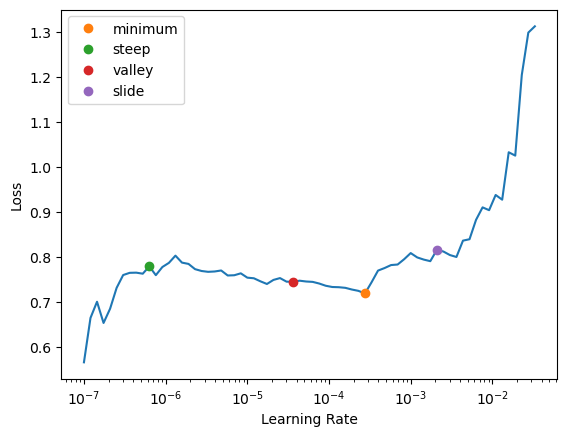

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.683350,0.664797,0.605000,00:23
1,0.261247,0.236147,0.905000,00:22
2,0.187310,0.223240,0.900000,00:22


In [ ]:
for m_name, m_val in zip(
    learn.recorder.metric_names[1:-1], learn.recorder.final_record
):
    print(m_name, m_val)

train_loss 0.1873098611831665
valid_loss 0.2232401967048645
accuracy 0.8999999761581421


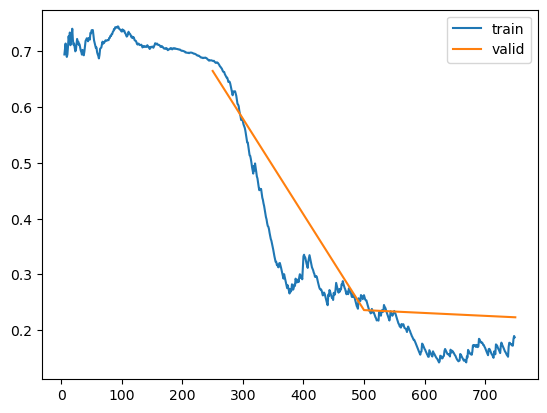

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test_topic_segmentation.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Low-Level API

This section demonstrates how you can migrate from using PyTorch to fast.ai `Datasets` and `DataLoaders` to recapture much of the fast.ai specific features unavailable when using basic PyTorch.

## Low-Level API: Example

### Step 1: HF objects

In [ ]:
model_cls = AutoModelForSequenceClassification
hf_logging.set_verbosity_error()

pretrained_model_name = "microsoft/deberta-v3-small"
n_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
    pretrained_model_name, model_cls=model_cls, config_kwargs={"num_labels": n_labels}
)

test_eq(hf_arch, "deberta_v2")
hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

print("=== config ===")
print(f"# of labels:\t{hf_config.num_labels}")
print("")
print("=== tokenizer ===")
print(f"Vocab size:\t\t{hf_tokenizer.vocab_size}")
print(f"Max # of tokens:\t{hf_tokenizer.model_max_length}")
print(
    f"Attributes expected by model in forward pass:\t{hf_tokenizer.model_input_names}"
)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


### Step 2: `Datasets`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_imdb_ds = imdb_ds.map(tokenize_func, batched=True)
proc_imdb_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

# turn Arrow into DataFrame (`ColSplitter` only works with `DataFrame`s)
train_df = pd.DataFrame(proc_imdb_ds)
train_df.head()

# define dataset splitter
splitter = ColSplitter("is_valid")
splits = splitter(imdb_df)

# define how we want to build our inputs and targets
def _build_inputs(example):
    return {
        fwd_arg_name: example[fwd_arg_name]
        for fwd_arg_name in hf_tokenizer.model_input_names
        if fwd_arg_name in list(example.keys())
    }


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(
    items=train_df, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1
)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [ ]:
print("Items in train|validation datasets: ", len(dsets.train), len(dsets.valid))

example = dsets.valid[0]
# example

print(f"Items in each example: {len(example)}")
print(f"Example inputs: {list(example[0].keys())}")
print(f"Example target(s): {example[1]}")

Items in train|validation datasets:  1000 200
Items in each example: 2
Example inputs: ['input_ids', 'token_type_ids', 'attention_mask']
Example target(s): 1


### Step 3: `DataLoaders`

In [ ]:
def sorted_dl_func(item):
    return len(item[0]["input_ids"])


data_collator = TextCollatorWithPadding(hf_tokenizer)
dls = dsets.dataloaders(
    batch_size=4,
    create_batch=data_collator,
    dl_type=partial(SortedDL, sort_func=sorted_dl_func),
)

In [ ]:
print(len(dls.train), len(dls.valid))

b = dls.valid.one_batch()
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0]))
print("")
print(b[1])

250 50
2

[CLS] BROADCAST NEWS opens with a series of brief vignettes that are a clever way of starting a story about TV anchors who have no clue as to what they're reporting about.<br /><br />At a speech before a group of would-be reporters, all of whom are bored by her presentation, most of them leave. When the last one exits, the co-host of the event says quietly to HOLLY HUNTER: "I don't think there will be any Q&A." Subtle line in a brilliantly written low-key comedy, a farce about the show biz aspect of TV anchoring.<br /><br />WILLIAM HURT is the inept news anchor who finds himself working with HOLLY HUNTER as the network anchorman. Hurt badly needs help in remedial reporting and Holly refuses to take the bait--at first. He knows he's only capable of looking good, but is not a reporter. He proves to be a quick study as long as his earpiece is working and he's getting all the straight info from executive producer Hunter.<br /><br />Holly's other anchor friend (ALBERT BROOKS) help

### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

3


In [ ]:
# NOPE: Will work assuming we define a suitable `show_batch()`` method for our examples
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `one_batch()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 1426)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 1426 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 1426 x 3072     
Linear                        

### Step 5: Train

SuggestedLRs(minimum=6.309573450380412e-08, steep=0.005248074419796467, valley=0.00015848931798245758, slide=0.0003311311302240938)

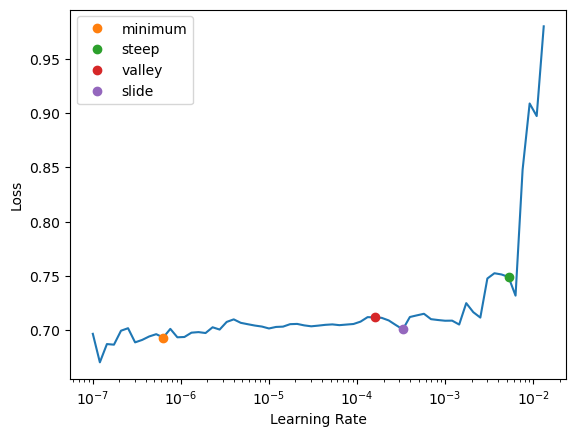

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.684787,0.674030,0.490000,00:26
1,0.248161,0.219310,0.915000,00:20
2,0.159760,0.219764,0.920000,00:19


In [ ]:
for m_name, m_val in zip(
    learn.recorder.metric_names[1:-1], learn.recorder.final_record
):
    print(m_name, m_val)

train_loss 0.15975962579250336
valid_loss 0.21976438164710999
accuracy 0.9200000166893005


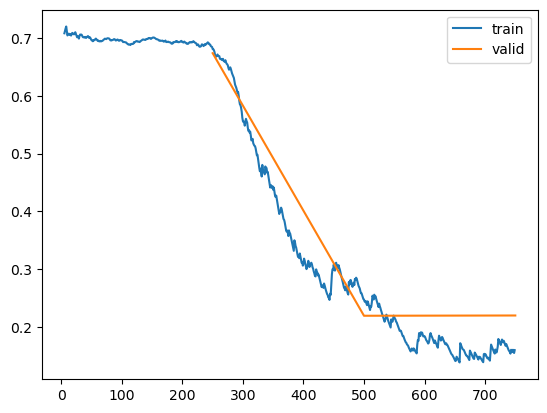

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results()

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
# AttributeError: 'DataLoader' object has no attribute 'new'
learn.export("../models/test_text_core_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Tests

The tests below to ensure the core DataBlock code above works for **all** pretrained sequence classification models available in Hugging Face.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained classification models you are working with ... and if any of your pretrained sequence classification models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

## Mid-level API

### Tests

The tests below to ensure the core DataBlock code above works for **all** pretrained sequence classification models available in Hugging Face.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained classification models you are working with ... and if any of your pretrained sequence classification models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

## Export -

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()